In [1]:
import os 
import sys
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import scipy.linalg as LA
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

sys.path.append('../')
import SRC.utils.plot_spinup as plotting

from matplotlib import animation, rc
plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'


In [2]:
fp      = '../Synthetic/farinotti_corrected/dx50/exp_01_elevation_dependent/hdf5/LK_*.nc'
files   = sorted(glob.glob(fp))

xarrays = []
for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(data = np.linspace(1.90, 2.05, 16), name='Delta_MB'))

mf_dataset['z_s'] = mf_dataset.z_s.where((mf_dataset.z_s - mf_dataset.z_b) != 10., mf_dataset.z_b)
mf_dataset["H"]   = mf_dataset.z_s - mf_dataset.z_b

Vol = mf_dataset.H.integrate("x") / mf_dataset.H.isel(t=1).integrate("x")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


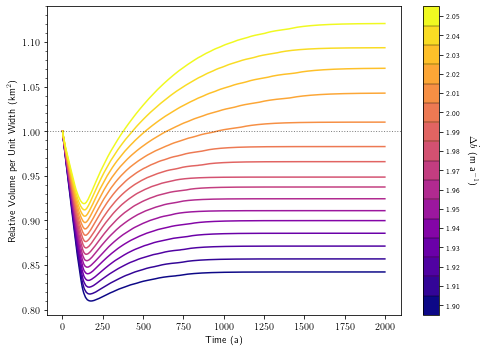

In [13]:
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0.8, 1.1, 0.05)
minor_ticks = np.arange(0.8, 1.15, 0.01)

title = r'\begin{center}'  + \
        r'$2000 \; \rm{a}$ spin-up of Synthetic Glacier (Surging Tributary) \\'  + \
        r'using a support vector regression of EMY $\dot b$ data (elevation dependent)'  + \
        r' \end{center}'

fig, ax = plotting.plot_volume(mf_dataset, precision=2) #, title=title

ax.set_yticks(major_ticks);
ax.set_yticks(minor_ticks, minor=True);

fig.savefig('/Users/andrewnolan/Desktop/mb_gridsearch_Vol.eps', facecolor='w', bbox_inches = 'tight', edgecolor='k')

In [ ]:
title = r'\begin{center} ' +\
        r'$z_{\rm s} \left( t=2000 \right)$ of Synthetic Glacier (Surging Tributary) \\' +\
        r'using a support vector regression of EMY $\dot b$ data (elevation dependent)' +\
        r' \end{center}'

fig, ax = plotting.plot_final_z_s(mf_dataset, precision=2, title=title)

In [ ]:
Data = mf_dataset.isel(Delta_MB=10)

In [ ]:
Data.H.max()

In [ ]:
fig, ax = plt.subplots(1,1)

for delta_mb in Vol.Delta_MB:
    color = colormap(normalize(delta_mb))
    ax.plot(Vol.t[1:], 
            np.abs(Vol.sel(Delta_MB=delta_mb)[1:].differentiate('t')), color=color)
    
cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=mf_dataset.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')


cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=6) 


ax.axhline(1e-6, ls=':', c='k', alpha=0.5)
ax.set_yscale('log')


ax.set_ylabel(r'$\left| \frac{\partial V}{\partial t} \right|$', fontsize='xx-large')
ax.set_xlabel('Time (a)')
ax.set_title (r'$\left| \frac{\partial V}{\partial t} \right|$ for $2000 \; \rm{a}$ spin-up of Synthetic Glacier (Surging Tributary)')

#fig.savefig('../plots/farinotti_corrected/dVdt_1.9--2.0_dx_100.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6.6667,4))

ax.set_xlim(Data.x.min(), Data.x.max())
ax.set_ylim(Data.z_s.min()-25, Data.z_s.max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot( Data.x, Data.isel(t=1).z_b,color='saddlebrown')
ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=0).z_b, color='saddlebrown', alpha=0.5)

collection = ax.fill_between(Data.x, Data.isel(t=1).z_b, Data.isel(t=1).z_s, color='lightblue', alpha=0.5)

ax.plot(Data.x, Data.isel(t=1).z_s, 'k:', alpha=0.5, label='$z_s(t=0.0)$')
ax.legend(loc=2)


ax.set_title('$z_{{ \\rm s}} \\left( t=2000 \\right)$ of Synthetic Glacier (Surging Tributary) with $\\Delta \\dot{{b}} ={{{}}} \\; \\rm{{ m a^{{-1}}}}$ '.format(Data.Delta_MB.values))
ax.set_aspect(9)

line1, = ax.plot([], [], lw=2, color='lightblue', label='$z_s(t=0.0)$',)
line   = [line1]

def animate(i):
    if i == 0:
        ax.collections.clear()
        line[0].set_data(Data.x, Data.isel(t=i).z_s)
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))

        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=1).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=1).z_b, Data.isel(t=0).z_s, color='lightblue', alpha=0.5)
        ax.legend(loc=2)

    else:
        ax.collections.clear()
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i))
        line[0].set_data(Data.x,  Data.isel(t=i).z_s)
        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=i).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=i).z_b, Data.isel(t=i).z_s, color='lightblue', alpha=0.5)
    
        ax.legend(loc=2)


    return line



times    = np.arange(0, Data.t.shape[0], 10)
times[0] = 1.

anim = animation.FuncAnimation(fig, animate, 
                               frames=times, interval=150, blit=True)

plt.tight_layout()
plt.close()
anim

In [ ]:
anim.save('../plots/farinotti_corrected/DeltaMB=2.0_2000a_animation.mp4', fps=10, dpi=800)

# Old Bed 

Wild geometric instability.

In [15]:
fp      = '../Synthetic/Farinotti_smooth/Exp_01_elevation_dependent/hdf5/lk_pre_2000a_*.nc'
files   = sorted(glob.glob(fp))

xarrays = []
for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(data = np.linspace(2.00, 2.50, 51), name='Delta_MB'))

mf_dataset["H"] = mf_dataset.z_s - mf_dataset.z_b
Vol             = mf_dataset.H.integrate("x") / mf_dataset.H.isel(t=1).integrate("x")

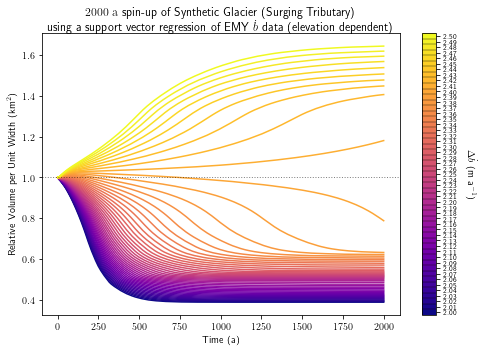

In [23]:
title = r'\begin{center}'  + \
        r'$2000 \; \rm{a}$ spin-up of Synthetic Glacier (Surging Tributary) \\'  + \
        r'using a support vector regression of EMY $\dot b$ data (elevation dependent)'  + \
        r' \end{center}'

fig, ax = plotting.plot_volume(mf_dataset, precision=2, title=title)

fig.savefig('../plots/Old_Bed_mb_gridsearch_Vol.png', dpi=800, facecolor='w', bbox_inches = 'tight', edgecolor='k')

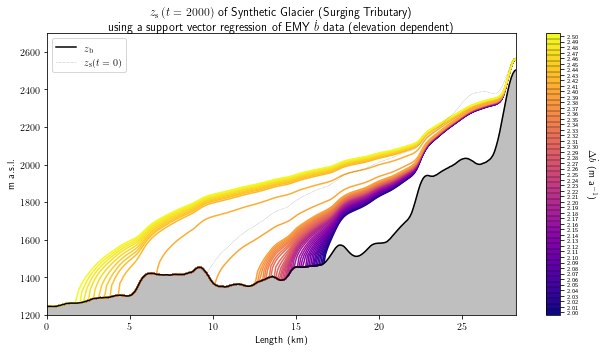

In [24]:
title = r'\begin{center} ' +\
        r'$z_{\rm s} \left( t=2000 \right)$ of Synthetic Glacier (Surging Tributary) \\' +\
        r'using a support vector regression of EMY $\dot b$ data (elevation dependent)' +\
        r' \end{center}'

fig, ax = plotting.plot_final_z_s(mf_dataset, precision=2, title=title)

fig.savefig('../plots/Old_Bed_mb_gridsearch_Z_s.png', dpi=800, facecolor='w', bbox_inches = 'tight', edgecolor='k')